# Importing Necessary Libraries

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal

In [76]:
welch = signal.welch

# Loading the Data Set

In [77]:
surface_dataset = pd.read_csv('../datasets/final/imu_data.csv')

# Feature Extraction Using Sliding Window Technique

In [104]:
window_size = 100
step_size = 100

features_df = pd.DataFrame(columns=[
    'accel_mean', 'accel_sd', 'accel_min', 'accel_max', 'accel_skew', 'accel_kurtosis', 
    'accel_peak_amp', 'accel_peak_amp_freq', 'accel_peak_pow', 'accel_peak_pow_freq', 
    'gyro_mean', 'gyro_sd', 'gyro_min', 'gyro_max', 'gyro_skew', 'gyro_kurtosis', 
    'gyro_peak_amp', 'gyro_peak_amp_freq', 'gyro_peak_pow', 'gyro_peak_pow_freq', 
    'surface'
])

def peak_amp(df, feature):
    sampling_freq = 100
    fds = np.fft.fft(df[feature])  # find FFT using numpy (frequency domain spectrum)
    freq_axis = np.fft.fftfreq(len(df[feature]), 1/sampling_freq)  # scaling the frequency axis using sampling rate
    pos_freqs = freq_axis > 0  # boolean mask to select only positive frequencies
    peak_amplitude = np.abs(np.max(fds[pos_freqs]))  # compute the magnitude to remove the complex parts
    peak_freq_index = np.argmax(fds[pos_freqs])
    peak_freq = freq_axis[peak_freq_index]
    return(peak_amplitude, peak_freq)

def peak_pow(df, feature):
    sampling_freq = 100
    signal = df[feature]
    frequencies, psd = welch(signal, sampling_freq, nperseg = 100)  # using welch's method calculate PSD with SciPy welch function
    psd_dB = 10 * np.log10(psd)  # convert PSD values to decibels scale
    peak_power = round(np.max(psd_dB), 2)  # find highest value of the PSD in decibels and round to 2 decimal places
    peak_power_freq = round(frequencies[np.argmax(psd_dB)])  # find the corresponding frequency ar peak power and also round it
    return(peak_power, peak_power_freq)

for i in range(0, len(surface_dataset), step_size):
    safe_bound = min(i + window_size, len(surface_dataset))  # prevent out of bound error by setting the upper bound of our window to the length of our dataset at most
    
    batch = surface_dataset.iloc[i:safe_bound]  # 1 second sample from our data set

    if len(batch) == window_size and batch['surface'].nunique() == 1:  # ensure our batch matches our window size and all surfaces are the same

    # Accelerometer Features

        peak_a, peak_a_freq = peak_amp(batch, 'accelerometer')
        peak_p, peak_p_freq = peak_pow(batch, 'accelerometer')
    
        accel_features = [
            np.mean(batch['accelerometer']),
            np.std(batch['accelerometer']),
            np.min(batch['accelerometer']),
            np.max(batch['accelerometer']),
            batch['accelerometer'].skew(),
            batch['accelerometer'].kurtosis(),
            peak_a,
            peak_a_freq,
            peak_p,
            peak_p_freq
        ]

    # Gyroscope Features

        gyro_peak_a, gyro_peak_a_freq = peak_amp(batch, 'gyro')
        gyro_peak_p, gyro_peak_p_freq = peak_pow(batch, 'gyro')
    
        gyro_features = [
            np.mean(batch['gyro']),
            np.std(batch['gyro']),
            np.min(batch['gyro']),
            np.max(batch['gyro']),
            batch['gyro'].skew(),
            batch['gyro'].kurtosis(),
            peak_a,
            peak_a_freq,
            peak_p,
            peak_p_freq
        ]

        surface_label = batch.iloc[0]['surface']

        features_df.loc[len(features_df)] = accel_features + gyro_features + [surface_label]

In [105]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
features_df

,accel_mean,accel_sd,accel_min,accel_max,accel_skew,accel_kurtosis,accel_peak_amp,accel_peak_amp_freq,accel_peak_pow,accel_peak_pow_freq,gyro_mean,gyro_sd,gyro_min,gyro_max,gyro_skew,gyro_kurtosis,gyro_peak_amp,gyro_peak_amp_freq,gyro_peak_pow,gyro_peak_pow_freq,surface
0,1.017223,0.130018,0.671495,1.323532,-0.277893,-0.260511,2.664534,27.0,-26.27,28,4.238859,1.615000,0.895211,8.767034,0.187475,-0.130288,2.664534,27.0,-26.27,28,asphalt
1,1.016924,0.118206,0.652026,1.517054,0.871643,3.737929,2.078429,25.0,-27.10,27,3.769835,1.458798,0.929784,7.769315,0.624631,0.002245,2.078429,25.0,-27.10,27,asphalt
2,1.017196,0.118084,0.758808,1.258232,-0.076832,-0.514983,2.073233,38.0,-27.58,23,3.551275,1.422146,0.600545,7.712212,0.519343,0.401312,2.073233,38.0,-27.58,23,asphalt
3,1.018074,0.124662,0.747783,1.358358,-0.101122,-0.090979,1.847116,21.0,-24.88,29,4.629087,2.040026,0.316045,9.537329,0.386823,-0.627951,1.847116,21.0,-24.88,29,asphalt
4,1.016854,0.164820,0.549305,1.451492,-0.083732,0.905238,3.628161,21.0,-22.64,22,3.790298,1.839864,0.774900,9.563268,0.635038,0.160037,3.628161,21.0,-22.64,22,asphalt
5,1.026027,0.161615,0.553840,1.449061,-0.194978,0.743838,2.330740,15.0,-24.86,29,3.711983,1.496334,0.576814,7.602828,0.401016,-0.117501,2.330740,15.0,-24.86,29,asphalt
6,1.024045,0.174322,0.684960,1.671919,0.431936,0.757092,2.587518,25.0,-24.01,27,4.868587,1.558164,1.642926,9.956556,0.498818,0.708794,2.587518,25.0,-24.01,27,asphalt
7,1.035534,0.176669,0.638621,1.663844,0.332754,0.600833,2.653875,21.0,-24.01,31,4.144830,1.739066,0.455980,8.866471,0.151181,-0.343909,2.653875,21.0,-24.01,31,asphalt
8,1.024195,0.143282,0.585695,1.572645,0.260342,1.751938,2.898617,32.0,-25.99,28,3.696541,2.088255,0.892215,10.470187,1.104328,0.939940,2.898617,32.0,-25.99,28,asphalt
9,1.023416,0.171812,0.693610,1.514336,0.561101,0.187644,2.400857,38.0,-26.05,21,3.784816,2.214675,0.364618,10.104268,0.946703,0.323394,2.400857,38.0,-26.05,21,asphalt


In [106]:
surface_counts = features_df.groupby('surface').size()
print(surface_counts)

surface
asphalt     148
concrete    147
grass       132
stones      162
tile        122
dtype: int64


### Dimensionality Reduction

### Principal Component Analysis

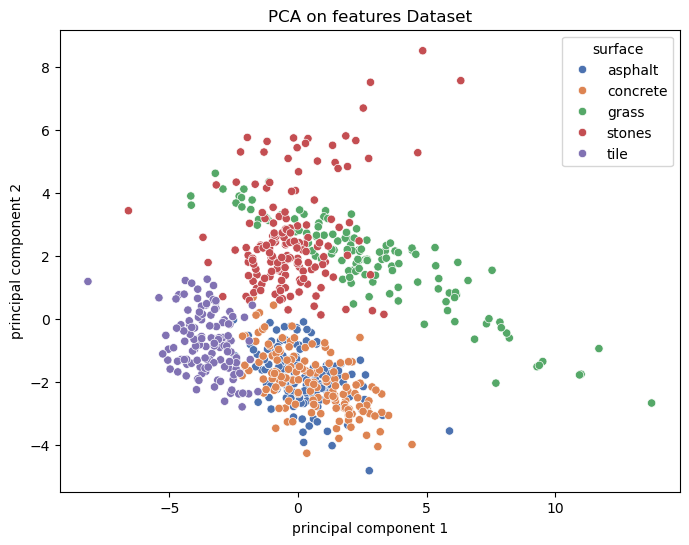

In [107]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = features_df.drop(columns=['surface'])
Y = pd.DataFrame({'surface': features_df['surface']})

X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

plt.figure(figsize=(8,6))
sns.scatterplot(x="principal component 1", y="principal component 2", data=principalDf, hue=Y['surface'], palette="deep")
plt.title("PCA on features Dataset")
plt.show()

### Finding the smallest number of principal components that capture a large portion of the variance

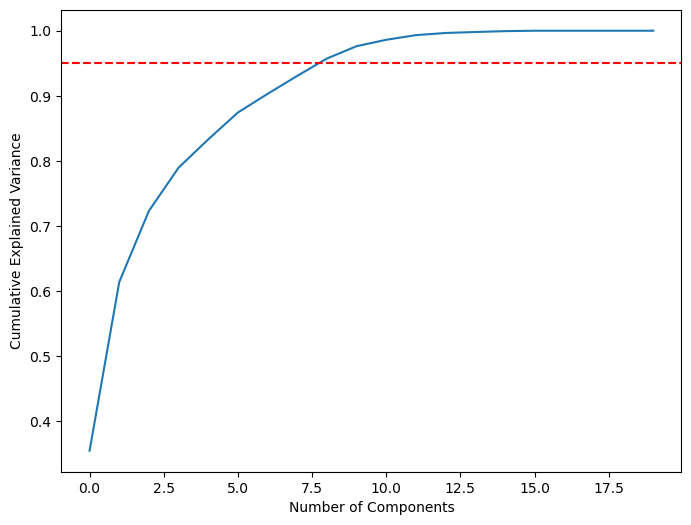

In [108]:
pca = PCA().fit(X)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

9 features is pretty good

In [109]:
column_names=[
    'accel_mean', 'accel_sd', 'accel_min', 'accel_max', 'accel_skew', 'accel_kurtosis', 
    'accel_peak_amp', 'accel_peak_amp_freq', 'accel_peak_pow', 'accel_peak_pow_freq', 
    'gyro_mean', 'gyro_sd', 'gyro_min', 'gyro_max', 'gyro_skew', 'gyro_kurtosis', 
    'gyro_peak_amp', 'gyro_peak_amp_freq', 'gyro_peak_pow', 'gyro_peak_pow_freq', 
    'surface'
]

principal_components = pca.components_

top_feature_indexes = [abs(pc).argsort()[-1] for pc in principal_components]  # take absolute value because the magnitude shows the importance/weight wether positive or negative

top_feature_names = [column_names[i] for i in top_feature_indexes]

# print(top_feature_names)

print("Feature Importance by PCA:")

seen = []
creme_de_la_creme = []
for feature_name in top_feature_names:
    if feature_name not in seen:
        print(f"{len(seen) + 1} . {feature_name}")
        seen.append(feature_name)
    else:
        creme_de_la_creme.append(feature_name)

print("Top Features by PCA:")  # these features repeat
for value in creme_de_la_creme:
    print(value)

Feature Importance by PCA:
1 . accel_sd
2 . gyro_peak_pow_freq
3 . gyro_skew
4 . gyro_sd
5 . accel_skew
6 . accel_kurtosis
7 . gyro_min
8 . gyro_peak_amp
9 . gyro_peak_amp_freq
10 . accel_mean
11 . accel_min
12 . gyro_kurtosis
13 . gyro_mean
14 . gyro_max
15 . accel_peak_amp_freq
16 . accel_peak_pow
17 . accel_peak_pow_freq
18 . accel_peak_amp
Top Features by PCA:
accel_min
accel_sd


## K-means clustering 2 principal components

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


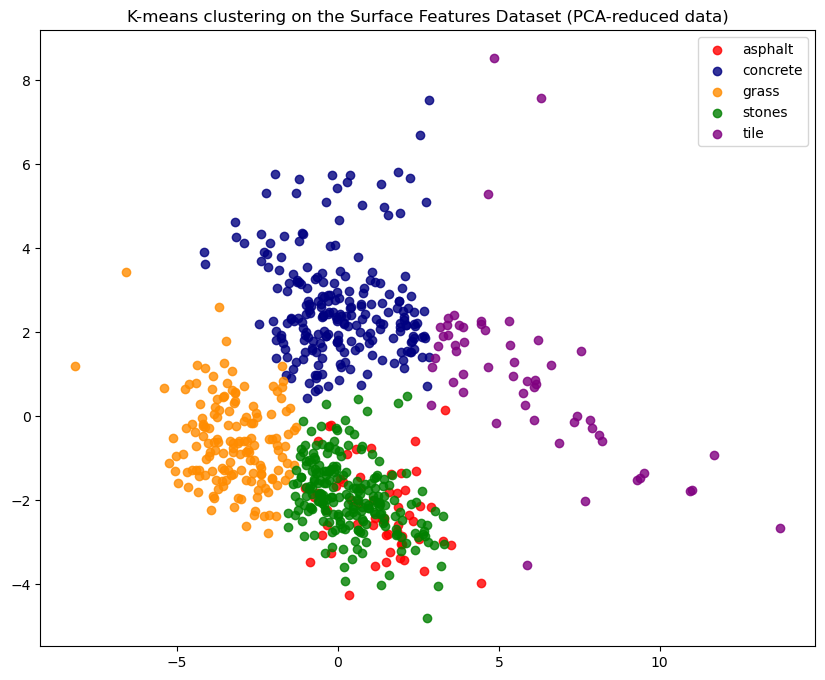

In [84]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,8))
colors = ["red", "navy", "darkorange", "green", "purple"]
lw = 1

for color, i, target_label in zip(colors, [0, 1, 2, 3, 4], Y['surface'].unique()):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], color=color, alpha=.8, lw=lw, label=target_label)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("K-means clustering on the Surface Features Dataset (PCA-reduced data)")
plt.show()